# Embedding

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
from utils.utils import CustomDataset, epsilon_graph, knn_graph
from torchvision import transforms
from torch.utils.data import  DataLoader, TensorDataset, random_split
from models.AE_model import Autoencoder
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelPropagation
from models.GNN_Model import GCN_Classifier
import networkx as nx


np.random.seed(42)
tf.random.set_seed(42)

2024-01-31 12:08:23.586259: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 12:08:23.609829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 12:08:23.609848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 12:08:23.610422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 12:08:23.614279: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Definir o caminho para o diretório contendo as imagens de treino e teste
data_dir = 'dataset/Kather_texture_2016_image_tiles_5000'
samples, labels = list(), list()

for nome_pasta in os.listdir(data_dir):
    for nome_arquivo in os.listdir(os.path.join(data_dir, nome_pasta)):
        samples.append(os.path.join(data_dir + '/' + nome_pasta,nome_arquivo))
        labels.append(int(nome_pasta[:2]))

all_data = pd.DataFrame({'path':samples,'label':labels})
all_data['label'] = all_data['label'].astype('str')

In [3]:
all_data.head()

,path,label
0,dataset/Kather_texture_2016_image_tiles_5000/0...,7
1,dataset/Kather_texture_2016_image_tiles_5000/0...,7
2,dataset/Kather_texture_2016_image_tiles_5000/0...,7
3,dataset/Kather_texture_2016_image_tiles_5000/0...,7
4,dataset/Kather_texture_2016_image_tiles_5000/0...,7


In [4]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
dataset = CustomDataset(dataframe=all_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
model = Autoencoder()

In [6]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [7]:
# Train the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    # if epoch % 5== 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 0.0207
Epoch [2/20], Loss: 0.0113
Epoch [3/20], Loss: 0.0124
Epoch [4/20], Loss: 0.0113
Epoch [5/20], Loss: 0.0092
Epoch [6/20], Loss: 0.0123
Epoch [7/20], Loss: 0.0083
Epoch [8/20], Loss: 0.0103
Epoch [9/20], Loss: 0.0073
Epoch [10/20], Loss: 0.0109
Epoch [11/20], Loss: 0.0083
Epoch [12/20], Loss: 0.0059
Epoch [13/20], Loss: 0.0082
Epoch [14/20], Loss: 0.0072
Epoch [15/20], Loss: 0.0049
Epoch [16/20], Loss: 0.0057
Epoch [17/20], Loss: 0.0058
Epoch [18/20], Loss: 0.0057
Epoch [19/20], Loss: 0.0055
Epoch [20/20], Loss: 0.0063


<Figure size 1600x1200 with 0 Axes>

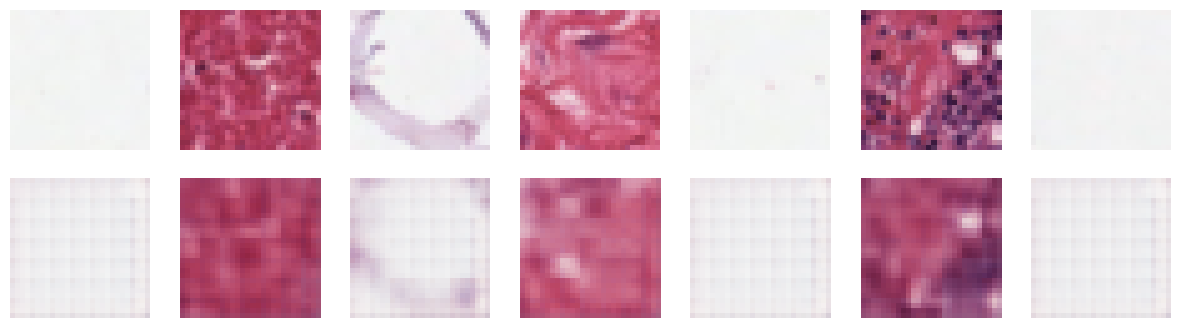

In [8]:
with torch.no_grad():
    for data in dataloader:
        recon = model(data)
        break
         
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

In [9]:
embed_dataloader = DataLoader(dataset, batch_size=5000, shuffle=False)

In [10]:
for image in embed_dataloader:
    X = model.encoder(image)
y = torch.tensor(all_data.label.astype(int))

In [11]:
X.shape

torch.Size([5000, 392])

## Seleção de parcela dos dados para aprendizado Semi-Supervisionado e Criação de Grafos Artificiais

In [12]:
# Indices de todos os elementos do conjunto
all_elements = torch.tensor(list(range(X.shape[0])))

# Indices de treino
train_indices = torch.tensor(random.sample(all_elements.tolist(), int(0.1 * X.shape[0])))

# Indices de teste, aux_mask é apenas para criar o indice de teste
aux_mask = torch.isin(all_elements, train_indices)
test_indices = all_elements[~aux_mask]

# Rótulos de treino
train_labels = y[train_indices]

# Rótulos de teste
test_labels = y[test_indices]

# Mask com todos os dados de treino iguais a -1, caso seja necessário usar
training_mask = np.full(X.shape[0], -1)
for i in train_indices:
    training_mask[i] = y[i]

In [13]:
# Criando um objeto custom data com os rótulos de treino e teste
dataset = TensorDataset(X, y)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Configuração do DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Criação de Grafos Artificiais
G1 = epsilon_graph(X.detach().numpy(), 0.2)
G2 = knn_graph(X.detach().numpy(), 3)

In [23]:
# Gerando o grafo a partir do algoritmo kmeans
# Aplique K-Means com k=8
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_clusters = kmeans.fit_predict(X.detach().numpy())

# Crie um grafo para cada cluster
k_neighbors = 3  # Número de vizinhos para o grafo KNN

# Crie um grafo global
global_graph = nx.Graph()

for cluster_label in range(8):
    # Selecione os pontos pertencentes ao cluster
    cluster_points = X.detach().numpy()[kmeans_clusters == cluster_label]

    # Crie o grafo KNN para o cluster atual
    cluster_graph = knn_graph(cluster_points, k_neighbors)

    # Adicione o grafo do cluster ao grafo global
    global_graph.add_nodes_from(cluster_graph.nodes)
    global_graph.add_edges_from(cluster_graph.edges)

In [24]:
print(nx.number_connected_components(global_graph))
print(len(global_graph.nodes()))

1
1260


# Clasificação dos dados

In [ ]:
# Dicionário para guardar o resultado da classificação
resultado_classificação = dict()

## Aplicar o KMeans sem rótulos para fazer a divisão dos grafos para o LabelPropagation + validação

In [ ]:
modelo_kmeans = KMeans(n_clusters=8)
grupos = modelo_kmeans.fit_predict(X.detach().numpy())

In [ ]:
# Distribuição do kmeans
torch.bincount(torch.tensor(grupos))

In [ ]:
label_prop_model = LabelPropagation()
label_prop_model.fit(X.detach().numpy(), training_mask)
predict_lp = label_prop_model.predict(X.detach().numpy())

## SVC + Self Training + validação

In [ ]:
import numpy as np
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
svc = SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(X.detach().numpy(), training_mask)

In [ ]:
y_pred = self_training_model.predict(X.detach().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print(accuracy_score(y, y_pred))
print(f1_score(y, y_pred, average='weighted'))

In [ ]:
print(accuracy_score(y, grupos))

## GNN + validação

In [ ]:
GNN = GCN_Classifier(X.shape[0], 64, 8)
criterion = nn.MSELoss()
optimizer_GNN = optim.Adam(GNN.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
# Treinamento
num_epochs = 100

for epoch in range(num_epochs):
    GNN.train()
    total_loss = 0

    for batch in train_loader:
        print(type(batch))
        optimizer.zero_grad()  # Zera os gradientes
        output = GNN(batch)
        loss = criterion(output, batch.y)
        loss.backward()  # Retropropagação
        optimizer.step()  # Atualização dos parâmetros

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')